In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
# style.use('fivethirtyeight')
%matplotlib inline

pd.plotting.register_matplotlib_converters()

In [2]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

In [3]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [4]:
df.timestamp = df.timestamp.str.replace('[', '')
df.timestamp = df.timestamp.str.replace(']', '')
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [5]:
df.request_method = df.request_method.str.replace('"', '')
df.request_agent = df.request_agent.str.replace('"', '')
df.destination = df.destination.str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)


In [6]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [7]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [8]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [9]:
df_ts_size = df['size_mb'].resample('30T').median()

In [10]:
df_ts_size.head()

timestamp
2019-04-16 19:30:00+00:00    0.486491
2019-04-16 20:00:00+00:00    0.486506
2019-04-16 20:30:00+00:00    0.486503
2019-04-16 21:00:00+00:00    0.486506
2019-04-16 21:30:00+00:00    0.486509
Freq: 30T, Name: size_mb, dtype: float64

In [11]:
idx = pd.date_range(df_ts_size.sort_index().index.min(),
                   df_ts_size.sort_index().index.max(),
                   freq='30min'
                   )

In [12]:
df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)

In [13]:
df_ts_size.head(30)

2019-04-16 19:30:00+00:00    0.486491
2019-04-16 20:00:00+00:00    0.486506
2019-04-16 20:30:00+00:00    0.486503
2019-04-16 21:00:00+00:00    0.486506
2019-04-16 21:30:00+00:00    0.486509
2019-04-16 22:00:00+00:00    0.486512
2019-04-16 22:30:00+00:00    0.486687
2019-04-16 23:00:00+00:00    0.000000
2019-04-16 23:30:00+00:00    0.000097
2019-04-17 00:00:00+00:00    0.000000
2019-04-17 00:30:00+00:00    0.002550
2019-04-17 01:00:00+00:00    0.000332
2019-04-17 01:30:00+00:00    0.486511
2019-04-17 02:00:00+00:00    0.486511
2019-04-17 02:30:00+00:00    0.003489
2019-04-17 03:00:00+00:00    0.482626
2019-04-17 03:30:00+00:00    0.486662
2019-04-17 04:00:00+00:00    0.001266
2019-04-17 04:30:00+00:00    0.003489
2019-04-17 05:00:00+00:00    0.486492
2019-04-17 05:30:00+00:00    0.003396
2019-04-17 06:00:00+00:00    0.003396
2019-04-17 06:30:00+00:00    0.000000
2019-04-17 07:00:00+00:00    0.000000
2019-04-17 07:30:00+00:00    0.000000
2019-04-17 08:00:00+00:00    0.000000
2019-04-17 0

In [14]:
start_date_train = df_ts_size.head(1).index[0]
end_date_train = '2019-04-17 23:30:00'
start_date_test = '2019-04-18 00:00:00'


In [15]:
train = df_ts_size[:end_date_train]
test = df_ts_size[start_date_test:]

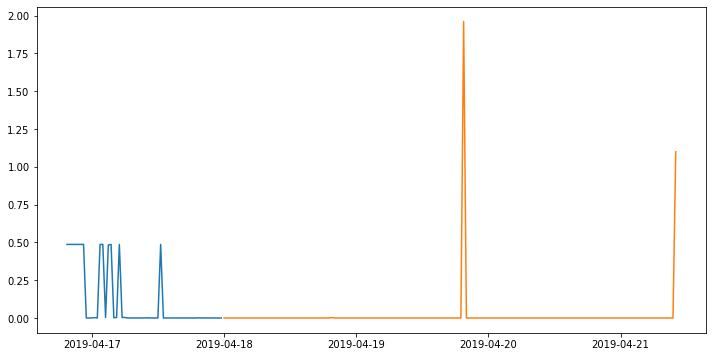

In [16]:
plt.figure(figsize=(12,6))
plt.plot(train)
plt.plot(test)
plt.show()

In [17]:
short_rolling = train.rolling(window=12).mean()
short_rolling.head(20)

2019-04-16 19:30:00+00:00         NaN
2019-04-16 20:00:00+00:00         NaN
2019-04-16 20:30:00+00:00         NaN
2019-04-16 21:00:00+00:00         NaN
2019-04-16 21:30:00+00:00         NaN
2019-04-16 22:00:00+00:00         NaN
2019-04-16 22:30:00+00:00         NaN
2019-04-16 23:00:00+00:00         NaN
2019-04-16 23:30:00+00:00         NaN
2019-04-17 00:00:00+00:00         NaN
2019-04-17 00:30:00+00:00         NaN
2019-04-17 01:00:00+00:00    0.284058
2019-04-17 01:30:00+00:00    0.284059
2019-04-17 02:00:00+00:00    0.284060
2019-04-17 02:30:00+00:00    0.243809
2019-04-17 03:00:00+00:00    0.243485
2019-04-17 03:30:00+00:00    0.243498
2019-04-17 04:00:00+00:00    0.203061
2019-04-17 04:30:00+00:00    0.162795
2019-04-17 05:00:00+00:00    0.203336
Freq: 30T, Name: size_mb, dtype: float64

In [18]:
long_rolling = train.rolling(window=24).mean()

Text(0, 0.5, 'Size (MB)')

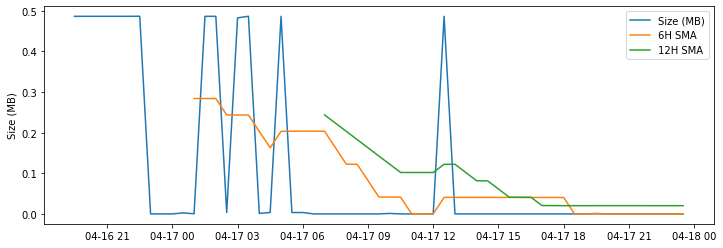

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(train.index, train, label='Size (MB)')
ax.plot(short_rolling.index, short_rolling, label='6H SMA')
ax.plot(long_rolling.index, long_rolling, label='12H SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

In [20]:
ema_short = train.ewm(span=12, adjust=False).mean()
ema_short[0:20]

2019-04-16 19:30:00+00:00    0.486491
2019-04-16 20:00:00+00:00    0.486494
2019-04-16 20:30:00+00:00    0.486495
2019-04-16 21:00:00+00:00    0.486497
2019-04-16 21:30:00+00:00    0.486499
2019-04-16 22:00:00+00:00    0.486501
2019-04-16 22:30:00+00:00    0.486529
2019-04-16 23:00:00+00:00    0.411679
2019-04-16 23:30:00+00:00    0.348358
2019-04-17 00:00:00+00:00    0.294765
2019-04-17 00:30:00+00:00    0.249809
2019-04-17 01:00:00+00:00    0.211428
2019-04-17 01:30:00+00:00    0.253748
2019-04-17 02:00:00+00:00    0.289558
2019-04-17 02:30:00+00:00    0.245547
2019-04-17 03:00:00+00:00    0.282021
2019-04-17 03:30:00+00:00    0.313504
2019-04-17 04:00:00+00:00    0.265468
2019-04-17 04:30:00+00:00    0.225163
2019-04-17 05:00:00+00:00    0.265368
Freq: 30T, Name: size_mb, dtype: float64

In [21]:
ema_long = train.ewm(span=24, adjust=False).mean()
ema_long[0:30]

2019-04-16 19:30:00+00:00    0.486491
2019-04-16 20:00:00+00:00    0.486492
2019-04-16 20:30:00+00:00    0.486493
2019-04-16 21:00:00+00:00    0.486494
2019-04-16 21:30:00+00:00    0.486495
2019-04-16 22:00:00+00:00    0.486497
2019-04-16 22:30:00+00:00    0.486512
2019-04-16 23:00:00+00:00    0.447591
2019-04-16 23:30:00+00:00    0.411792
2019-04-17 00:00:00+00:00    0.378848
2019-04-17 00:30:00+00:00    0.348744
2019-04-17 01:00:00+00:00    0.320871
2019-04-17 01:30:00+00:00    0.334123
2019-04-17 02:00:00+00:00    0.346314
2019-04-17 02:30:00+00:00    0.318888
2019-04-17 03:00:00+00:00    0.331987
2019-04-17 03:30:00+00:00    0.344361
2019-04-17 04:00:00+00:00    0.316913
2019-04-17 04:30:00+00:00    0.291839
2019-04-17 05:00:00+00:00    0.307412
2019-04-17 05:30:00+00:00    0.283090
2019-04-17 06:00:00+00:00    0.260715
2019-04-17 06:30:00+00:00    0.239858
2019-04-17 07:00:00+00:00    0.220669
2019-04-17 07:30:00+00:00    0.203015
2019-04-17 08:00:00+00:00    0.186774
2019-04-17 0

Text(0, 0.5, 'Size (MB)')

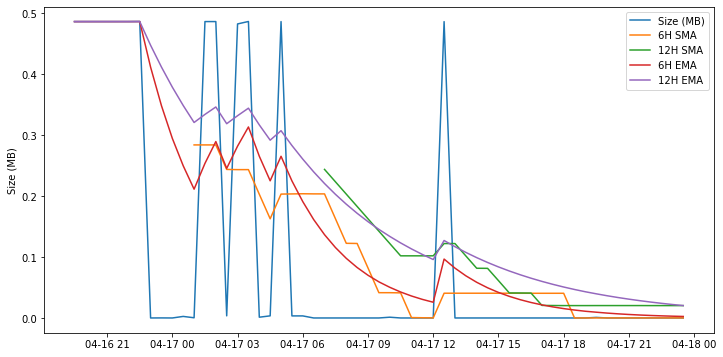

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train.index, train, label='Size (MB)')

ax.plot(short_rolling.index, short_rolling, label='6H SMA')
ax.plot(long_rolling.index, long_rolling, label='12H SMA')
ax.plot(ema_short.index, ema_short, label='6H EMA')
ax.plot(ema_long.index, ema_long, label='12H EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')




In [23]:
yhat = pd.DataFrame(dict(actual=test))

In [24]:
yhat['moving_avg_forecast'] = ema_long.iloc[-1]
yhat['moving_avg_forecast'].head()

2019-04-18 00:00:00+00:00    0.020349
2019-04-18 00:30:00+00:00    0.020349
2019-04-18 01:00:00+00:00    0.020349
2019-04-18 01:30:00+00:00    0.020349
2019-04-18 02:00:00+00:00    0.020349
Freq: 30T, Name: moving_avg_forecast, dtype: float64

In [25]:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

In [26]:
yhat.head()

,actual,moving_avg_forecast,error
2019-04-18 00:00:00+00:00,0.0,0.020349,0.020349
2019-04-18 00:30:00+00:00,0.0,0.020349,0.020349
2019-04-18 01:00:00+00:00,0.0,0.020349,0.020349
2019-04-18 01:30:00+00:00,0.0,0.020349,0.020349
2019-04-18 02:00:00+00:00,0.0,0.020349,0.020349


In [27]:
q3 = yhat.error.describe().loc['75%']
q1 = yhat.error.describe().loc['25%']

In [28]:
ub = q3 + 3*(q3-q1+.1)
lb = q1 - 3*(q3-q1+.1)

In [29]:
yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

In [30]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2019-04-19 19:30:00+00:00,1.961066,0.020349,1.940717,3.734528
2019-04-21 10:00:00+00:00,1.099591,0.020349,1.079242,2.298736


In [31]:
yhat[yhat.pct_b < 0]

,actual,moving_avg_forecast,error,pct_b
